<a href="https://colab.research.google.com/github/4ry1337/CollaborationFiltering/blob/arizona/Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Overview
The goal is to build a recommendation system that predicts the likelihood of a user liking a specific movie, based on their past ratings. The system uses the Movielens dataset (small version), which contains:

Ratings.csv: User ratings for movies.
Movies.csv: Details of the movies.

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile

import keras
from keras import layers
from keras import ops

# Load the data and apply preprocessing

Downloading the Data: The dataset is fetched from the MovieLens website, which provides user-movie ratings.

Unzipping the Data: The dataset is extracted if it hasn’t been already.

Encoding Users and Movies:
Users and movies are mapped to unique integer indices for embedding purposes

Mappings (user2user_encoded, movie2movie_encoded) allow conversion between original IDs and encoded values.

Dataset Statistics:
Number of users, movies, and the range of ratings are calculated

Normalization:
Ratings are normalized between 0 and 1.

In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

978202/978202 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting all the files now...
Done!


In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


# Prepare training and validation data

The dataset is shuffled and split into training (90%) and validation (10%) sets.

Input (x) consists of user and movie IDs.

Target (y) consists of normalized ratings

In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# Model

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).



## Embedding Layers

User Embedding: Each user is assigned a vector of size EMBEDDING_SIZE (e.g., 50 dimensions).

Movie Embedding: Each movie is similarly mapped to a vector of size EMBEDDING_SIZE.

These embeddings allow the model to learn the underlying patterns in user-movie interactions.

## Bias Layers

Each user and movie have an associated scalar bias, capturing individual tendencies:
Users might rate movies higher or lower in general.
Some movies may generally receive higher ratings than others.

## Dot Product

The similarity between user and movie embeddings is calculated via a dot product:

score=u⋅v+b u+b m

where:

u: User embedding vector

v: Movie embedding vector.

bu, bm: User and movie biases.

## Sigmoid Activation

The dot product result is passed through a sigmoid function to scale it to [0, 1]:

σ(x)= 1/1+e-x



In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return ops.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

Embedding: Creates trainable embeddings for users and movies.

Regularization: Helps prevent overfitting by penalizing overly large weights.

Forward

Input: A pair (user_id, movie_id).

Output: Predicted rating in [0, 1].

# Training

Loss Function
The model minimizes the Binary Crossentropy loss, comparing predicted ratings with true rating

This works well as the ratings are normalized to the [0, 1] range.

Optimizer
The Adam optimizer adjusts weights dynamically during training

Learning rate (𝜂) is set to 0.001 for stable convergence.

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 0.6572 - val_loss: 0.6200
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.6153 - val_loss: 0.6184
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.6090 - val_loss: 0.6143
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.6091 - val_loss: 0.6154
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.6081 - val_loss: 0.6133


Batch size: 64 samples are used per step.

Epochs: 5 iterations over the entire training dataset.

Validation data: Used to monitor model performance on unseen data.

# Plot training and validation loss

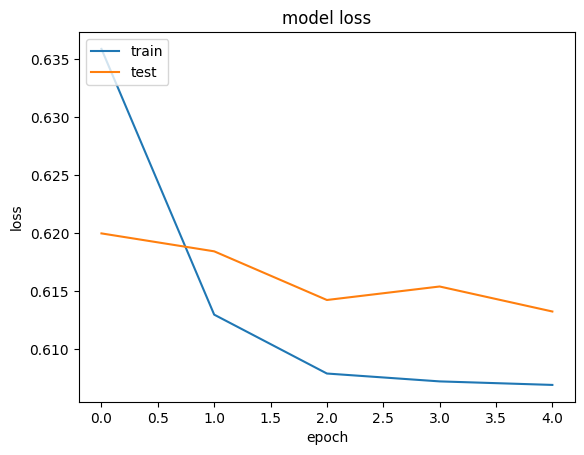

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Show top 10 movie recommendations to a user

After training, the model generates recommendations by:

Encoding user and movie IDs.

Predicting ratings for unseen movies.

Sorting and selecting the top N movies based on predicted ratings

In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Showing recommendations for user: 354
Movies with high ratings from user
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Starship Troopers (1997) : Action|Sci-Fi
Truman Show, The (1998) : Comedy|Drama|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Godfather: Part II, The (1974) : Crime|Drama
Glory (1989) : Drama|War
Graduate, The (1967) : Comedy|Drama|Romance
Touch of Evil (1958) : Crime|Film-Noir|Thriller
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Cool Hand Luke (1967) : Drama
Blue Velvet (1986) : Drama|Mystery|Thriller
Jungle Book, The (1967) : Animation|Children|Comedy|Musical
Muppet Christmas Carol, The (1992) : Children|Comedy|Musical
City of God (Cidade de Deus) (2002) : Action|Adventure|Crime|Drama|Thriller
